# RGB image compression

Compressing color images with PNG in the RGB domain.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os
#!pwd
!ln -sf ~/MRVC/src/deadzone_quantizer.py .
!ln -sf ~/MRVC/src/midtread_quantizer.py .
!ln -sf ~/MRVC/src/frame.py .
!ln -sf ~/MRVC/src/distortion.py .
!ln -sf ~/MRVC/src/information.py
!ln -sf ~/MRVC/src/debug.py
!ln -sf ~/MRVC/src/image_3.py
!ln -sf ~/MRVC/src/image_1.py
!ln -sf ../common.py .
import deadzone_quantizer as deadzone
import midtread_quantizer as midtread
import distortion
import image_3 as RGB_img
import image_1 as gray_img
import colored
import common

## Configuration area

In [2]:
# Prefix of the RGB image to be quantized.

home = os.environ["HOME"]
#fn = home + "/MRVC/sequences/stockholm/"
fn = home + "/MRVC/sequences/lena_color/"

# Embbeded (bit-plane encoding) quantization steps.
Q_steps = [2**i for i in range(7, -1, -1)]

# Non embbeded quatization steps (can produce loops in the RD curves
# due to the non-linearity of the integer division performed in the quantization).
#Q_steps = range(256, 0, -1)

print(Q_steps)

components = ['R', 'G', 'B']

first_quantizer = midtread
second_quantizer = deadzone

[128, 64, 32, 16, 8, 4, 2, 1]


## Generation of the RD curve

The RD curve can be generated with:

1. The RD curve of each RGB channel is computed, for a number of quantization steps.
2. The RD points are sorted by slopes.

image_3.read: /home/vruiz/MRVC/sequences/lena_color/000.png (512, 512, 3) uint8 512673 
255 1


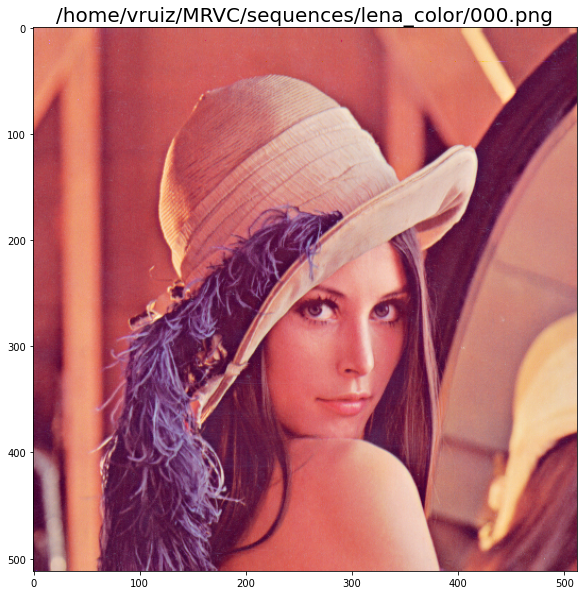

In [3]:
# Read the image and show it.
img = RGB_img.read(fn)
print(img.max(), img.min())
common.show(img, fn + "000.png")

## Some helper functions

In [4]:
# Number of bytes that a img "img" requires in disk.
def bytes_per_RGB_img(img, fn="img"):
    RGB_img.write(img, "/tmp/" + fn)
    length_in_bytes = os.path.getsize("/tmp/" + fn + "000.png")
    return length_in_bytes

# The same value, but in bits/pixel.
def bits_per_RGB_pixel(img, fn="img"):
    return 8*bytes_per_RGB_img(img, fn)/(img.shape[0]*img.shape[1])

# Specific version for grayscale images.
def bytes_per_gray_img(img, fn="img"):
    cv2.imwrite("/tmp/" + fn + "000.png", img)
    length_in_bytes = os.path.getsize("/tmp/" + fn + "000.png")
    print(colored.fore.GREEN + f"bytes_per_gray_img: /tmp/{fn}000.png", img.shape, img.dtype, length_in_bytes, colored.style.RESET)
    return length_in_bytes

# The same value, but in bits/pixel.
def bits_per_gray_pixel(img, fn="img"):
    return 8*bytes_per_gray_img(img, fn)/(img.shape[0]*img.shape[1])

# Entropy of a sequence of symbols (pixels). This is a theoretical measure
# of the compression ratio of the sequence.
def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

## RD curves of each RGB channel
Remember that the quantization indexes images must be normalized or equalized to be displayed properly.

In [5]:
def RD_curve(RGB_img, Q_steps, component, components, quantizer):
    RD_points = []
    component_index = components.index(component)
    for Q_step in Q_steps:
        component_img = RGB_img[..., component_index]
        dequantized_component_img, k = quantizer.quan_dequan(component_img, Q_step)
        k = k.astype(np.uint8)
        rate = common.bits_per_gray_pixel(k, component + str(Q_step) + '_')
        _distortion = distortion.MSE(component_img, dequantized_component_img)
        RD_points.append((rate, _distortion, component, Q_step))
        print(f"Q_step={Q_step:>3}, rate={rate:>.3f} bits/pixel, distortion={_distortion}")
    return RD_points

def R_RD_curve(RGB_img, Q_steps, components, quantizer):
    return RD_curve(RGB_img, Q_steps, 'R', components, quantizer)

def G_RD_curve(RGB_img, Q_steps, components, quantizer):
    return RD_curve(RGB_img, Q_steps, 'G', components, quantizer)

def B_RD_curve(RGB_img, Q_steps, components, quantizer):
    return RD_curve(RGB_img, Q_steps, 'B', components, quantizer)

In [6]:
R_points_first = R_RD_curve(img, Q_steps, components, first_quantizer)

Q_step=128, rate=1.000 bits/pixel, distortion=26296.20606994629
Q_step= 64, rate=1.743 bits/pixel, distortion=11000.751968383789
Q_step= 32, rate=2.384 bits/pixel, distortion=2422.599868774414
Q_step= 16, rate=3.300 bits/pixel, distortion=498.30433654785156
Q_step=  8, rate=4.249 bits/pixel, distortion=151.7968292236328
Q_step=  4, rate=5.215 bits/pixel, distortion=45.74916076660156
Q_step=  2, rate=6.056 bits/pixel, distortion=28.28997802734375
Q_step=  1, rate=7.253 bits/pixel, distortion=0.0


In [7]:
R_points_second = R_RD_curve(img, Q_steps, components, second_quantizer)

Q_step=128, rate=0.723 bits/pixel, distortion=6888.249038696289
Q_step= 64, rate=1.456 bits/pixel, distortion=1198.832046508789
Q_step= 32, rate=2.411 bits/pixel, distortion=327.65528869628906
Q_step= 16, rate=3.302 bits/pixel, distortion=79.94886779785156
Q_step=  8, rate=4.272 bits/pixel, distortion=17.562393188476562
Q_step=  4, rate=5.259 bits/pixel, distortion=3.5046234130859375
Q_step=  2, rate=6.255 bits/pixel, distortion=0.50872802734375
Q_step=  1, rate=7.253 bits/pixel, distortion=0.0


In [8]:
G_points_first = G_RD_curve(img, Q_steps, components, first_quantizer)

Q_step=128, rate=1.170 bits/pixel, distortion=3793.231876373291
Q_step= 64, rate=1.855 bits/pixel, distortion=372.383731842041
Q_step= 32, rate=2.691 bits/pixel, distortion=83.99261856079102
Q_step= 16, rate=3.628 bits/pixel, distortion=21.590763092041016
Q_step=  8, rate=4.596 bits/pixel, distortion=5.457340240478516
Q_step=  4, rate=5.557 bits/pixel, distortion=1.4627723693847656
Q_step=  2, rate=6.391 bits/pixel, distortion=0.5111579895019531
Q_step=  1, rate=7.595 bits/pixel, distortion=0.0


In [9]:
G_points_second = G_RD_curve(img, Q_steps, components, second_quantizer)

Q_step=128, rate=0.889 bits/pixel, distortion=4926.981876373291
Q_step= 64, rate=1.787 bits/pixel, distortion=1202.148868560791
Q_step= 32, rate=2.702 bits/pixel, distortion=333.809268951416
Q_step= 16, rate=3.632 bits/pixel, distortion=77.95367813110352
Q_step=  8, rate=4.608 bits/pixel, distortion=17.464847564697266
Q_step=  4, rate=5.600 bits/pixel, distortion=3.5024147033691406
Q_step=  2, rate=6.597 bits/pixel, distortion=0.5111579895019531
Q_step=  1, rate=7.595 bits/pixel, distortion=0.0


In [10]:
B_points_first = B_RD_curve(img, Q_steps, components, first_quantizer)

Q_step=128, rate=0.527 bits/pixel, distortion=1906.255672454834
Q_step= 64, rate=1.350 bits/pixel, distortion=311.199031829834
Q_step= 32, rate=2.082 bits/pixel, distortion=79.51397323608398
Q_step= 16, rate=2.997 bits/pixel, distortion=21.420467376708984
Q_step=  8, rate=3.969 bits/pixel, distortion=5.495784759521484
Q_step=  4, rate=4.927 bits/pixel, distortion=1.5001182556152344
Q_step=  2, rate=5.780 bits/pixel, distortion=0.5038871765136719
Q_step=  1, rate=6.969 bits/pixel, distortion=0.0


In [11]:
B_points_second = B_RD_curve(img, Q_steps, components, second_quantizer)

Q_step=128, rate=0.766 bits/pixel, distortion=7012.726375579834
Q_step= 64, rate=1.203 bits/pixel, distortion=1390.573055267334
Q_step= 32, rate=2.104 bits/pixel, distortion=343.678035736084
Q_step= 16, rate=3.015 bits/pixel, distortion=79.30205917358398
Q_step=  8, rate=3.981 bits/pixel, distortion=17.612483978271484
Q_step=  4, rate=4.972 bits/pixel, distortion=3.5380821228027344
Q_step=  2, rate=5.970 bits/pixel, distortion=0.5038871765136719
Q_step=  1, rate=6.969 bits/pixel, distortion=0.0


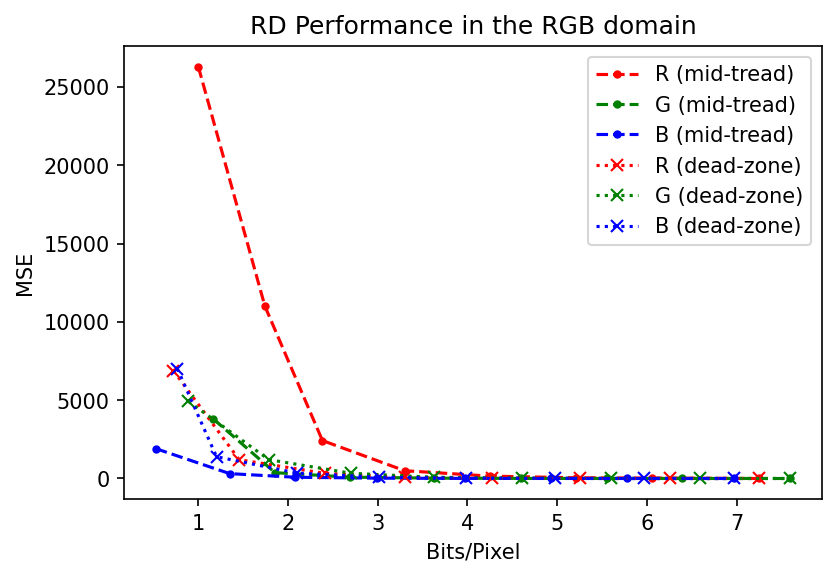

In [12]:
pylab.figure(dpi=150)
#pylab.scatter(*zip(*[(i[0], i[1]) for i in R_points]), c='r', marker='.', s=0.5, label='R')              
#pylab.scatter(*zip(*[(i[0], i[1]) for i in G_points]), c='g', marker='.', s=0.5, label='G')              
#pylab.scatter(*zip(*[(i[0], i[1]) for i in B_points]), c='b', marker='.', s=0.5, label='B')              
pylab.plot(*zip(*[(i[0], i[1]) for i in R_points_first]), c='r', marker='.', label=f"R ({first_quantizer.name})", linestyle="dashed")
pylab.plot(*zip(*[(i[0], i[1]) for i in G_points_first]), c='g', marker='.', label=f"G ({first_quantizer.name})", linestyle="dashed")
pylab.plot(*zip(*[(i[0], i[1]) for i in B_points_first]), c='b', marker='.', label=f"B ({first_quantizer.name})", linestyle="dashed")
pylab.plot(*zip(*[(i[0], i[1]) for i in R_points_second]), c='r', marker='x', label=f"R ({second_quantizer.name})", linestyle="dotted")              
pylab.plot(*zip(*[(i[0], i[1]) for i in G_points_second]), c='g', marker='x', label=f"G ({second_quantizer.name})", linestyle="dotted")
pylab.plot(*zip(*[(i[0], i[1]) for i in B_points_second]), c='b', marker='x', label=f"B ({second_quantizer.name})", linestyle="dotted")
pylab.title("RD Performance in the RGB domain")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

Let's use the mid-tread quantizer.

## Compute the slopes
In a different list for each component.

In [13]:
def compute_slopes(RD_points):
    extended_RD_points = [(0.0, 0.0, '', -1)] + RD_points
    counter = 0
    RD_slopes = [(9.0E9, RD_points[0])]
    points_iterator = iter(RD_points)
    next(points_iterator)
    for i in points_iterator:
        BPP = i[0] # Rate 
        #print(RD_points[counter])
        #delta_BPP = BPP - extended_RD_points[counter][0]
        delta_BPP = BPP - RD_points[counter][0]
        MSE = i[1] # Distortion
        #delta_MSE = MSE - extended_RD_points[counter][1] 
        delta_MSE = MSE - RD_points[counter][1] 
        #print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
        if delta_BPP > 0:
            slope = abs(delta_MSE/delta_BPP)
        else:
            slope = 0
        component = i[2]
        q_step = i[3]
        print((slope, i), delta_MSE, delta_BPP)
        RD_slopes.append((slope, i))
        counter += 1
    #RD_slopes.append((0.0, (0.0, RD_points[-1][2], 1)))
    return RD_slopes

R_slopes = compute_slopes(R_points_second)
G_slopes = compute_slopes(G_points_second)
B_slopes = compute_slopes(B_points_second)

(7755.555542104824, (1.456192947454975, 1198.832046508789, 'R', 64)) -5689.4169921875 0.7335924501216862
(912.7143755990315, (2.4106829621879307, 327.65528869628906, 'R', 32)) -871.1767578125 0.9544900147329556
(277.7756749845622, (3.30243282801835, 79.94886779785156, 'R', 16)) -247.7064208984375 0.8917498658304193
(64.31877169738051, (4.272390321965887, 17.562393188476562, 'R', 8)) -62.386474609375 0.9699574939475375
(14.252958567751566, (5.258695706112406, 3.5046234130859375, 'R', 4)) -14.057769775390625 0.9863053841465188
(3.006987178829501, (6.255007032889785, 0.50872802734375, 'R', 2)) -2.9958953857421875 0.9963113267773789
(0.5097079445869962, (7.253084525591924, 0.0, 'R', 1)) -0.50872802734375 0.998077492702139
(4145.1361584600445, (1.7874472892251074, 1202.148868560791, 'G', 64)) -3724.8330078125 0.8986032944202029
(949.398537559149, (2.702068036210697, 333.809268951416, 'G', 32)) -868.339599609375 0.9146207469855894
(275.0314507985764, (3.6323456102023797, 77.95367813110352, '

In [14]:
R_slopes

[(9000000000.0, (0.7226004973332889, 6888.249038696289, 'R', 128)),
 (7755.555542104824, (1.456192947454975, 1198.832046508789, 'R', 64)),
 (912.7143755990315, (2.4106829621879307, 327.65528869628906, 'R', 32)),
 (277.7756749845622, (3.30243282801835, 79.94886779785156, 'R', 16)),
 (64.31877169738051, (4.272390321965887, 17.562393188476562, 'R', 8)),
 (14.252958567751566, (5.258695706112406, 3.5046234130859375, 'R', 4)),
 (3.006987178829501, (6.255007032889785, 0.50872802734375, 'R', 2)),
 (0.5097079445869962, (7.253084525591924, 0.0, 'R', 1))]

In [15]:
G_slopes

[(9000000000.0, (0.8888439948049045, 4926.981876373291, 'G', 128)),
 (4145.1361584600445, (1.7874472892251074, 1202.148868560791, 'G', 64)),
 (949.398537559149, (2.702068036210697, 333.809268951416, 'G', 32)),
 (275.0314507985764, (3.6323456102023797, 77.95367813110352, 'G', 16)),
 (61.993121472483345, (4.608080161547003, 17.464847564697266, 'G', 8)),
 (14.082432013911179, (5.5995589663113705, 3.5024147033691406, 'G', 4)),
 (2.9986123356849124, (6.5971059577213005, 0.5111579895019531, 'G', 2)),
 (0.5121580205109124, (7.595153374790037, 0.0, 'G', 1))]

In [16]:
B_slopes

[(9000000000.0, (0.7662590185632749, 7012.726375579834, 'B', 128)),
 (12865.767399406319, (1.2032444812859984, 1390.573055267334, 'B', 64)),
 (1162.8510310243803, (2.1035274853858597, 343.678035736084, 'B', 32)),
 (289.9884134485901, (3.01520520870762, 79.30205917358398, 'B', 16)),
 (63.852964557208715, (3.981324411208266, 17.612483978271484, 'B', 8)),
 (14.200781168583955, (4.972424949156503, 3.5380821228027344, 'B', 4)),
 (3.0424500734221205, (5.969711633593769, 0.5038871765136719, 'B', 2)),
 (0.5044572173454175, (6.968581625315276, 0.0, 'B', 1))]

## Merge the RD slopes and sort them
By slope.

In [17]:
all_slopes = R_slopes + G_slopes + B_slopes
sorted_slopes = sorted(all_slopes, key=lambda x: x[0])[::-1]

In [18]:
sorted_slopes

[(9000000000.0, (0.7662590185632749, 7012.726375579834, 'B', 128)),
 (9000000000.0, (0.8888439948049045, 4926.981876373291, 'G', 128)),
 (9000000000.0, (0.7226004973332889, 6888.249038696289, 'R', 128)),
 (12865.767399406319, (1.2032444812859984, 1390.573055267334, 'B', 64)),
 (7755.555542104824, (1.456192947454975, 1198.832046508789, 'R', 64)),
 (4145.1361584600445, (1.7874472892251074, 1202.148868560791, 'G', 64)),
 (1162.8510310243803, (2.1035274853858597, 343.678035736084, 'B', 32)),
 (949.398537559149, (2.702068036210697, 333.809268951416, 'G', 32)),
 (912.7143755990315, (2.4106829621879307, 327.65528869628906, 'R', 32)),
 (289.9884134485901, (3.01520520870762, 79.30205917358398, 'B', 16)),
 (277.7756749845622, (3.30243282801835, 79.94886779785156, 'R', 16)),
 (275.0314507985764, (3.6323456102023797, 77.95367813110352, 'G', 16)),
 (64.31877169738051, (4.272390321965887, 17.562393188476562, 'R', 8)),
 (63.852964557208715, (3.981324411208266, 17.612483978271484, 'B', 8)),
 (61.99312

## Build the RD curve

At this point we have a list of RD points sorted by their slopes and we have to alternatives to compute the RD curve:

1. Suppose that the distortion of the reconstructed (dequantized) image is the sum of the distortions of each component, and do the same for the bit-rate.
2. Suppose that, because we are compressing a RGB image, the bit-rate of the compressed image can be slighly smaller than the addition of the bit-rates of the compressed components, basically because we will avoid extra headers.

We implement the second alterntive because it is more accurate.

In [19]:
def get_RD_curve_sorted_by_slopes(RGB_img, sorted_slopes, components, quantizer):
    points = []
    Q_steps_per_component = [256, 256, 256] # This should generate a black image.
    #Q_steps_per_component = [128, 128, 128] # This should generate a black image.
    for i in sorted_slopes:
        k = np.empty_like(RGB_img)
        y = np.empty_like(RGB_img)
        point = i[1]
        component = point[2]
        Q_step = point[3]
        Q_steps_per_component[components.index(component)] = Q_step
        #print(i, Q_steps_per_component)
        for c, QS in zip(components, Q_steps_per_component):
            y[..., components.index(c)], k[..., components.index(c)] = quantizer.quan_dequan(RGB_img[..., components.index(c)], QS)
            #print(c, QS,components.index(c))
            #for _y in range(10):
            #    for _x in range(10):
            #        print(RGB_img[_y, _x, components.index(c)], y[_y,_x, components.index(c)], end=' ')
            #    print()
        #y, k = quantizer.quan_dequan(RGB_img, Q_step)
        k = k.astype(np.uint8)
        rate = common.bits_per_RGB_pixel(k, str(Q_steps_per_component) + '_')
        _distortion = distortion.MSE(RGB_img, y)
        points.append((rate, _distortion))
        print(f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

RD_points_sorted_by_slopes = get_RD_curve_sorted_by_slopes(img, sorted_slopes, components, second_quantizer)

image_3.write: /tmp/[256, 256, 128]_000.png (512, 512, 3) uint8 25460 
Q_step=[256, 256, 128], rate=0.7769775390625 bits/pixel, distortion=18169.1
image_3.write: /tmp/[256, 128, 128]_000.png (512, 512, 3) uint8 35918 
Q_step=[256, 128, 128], rate=1.09613037109375 bits/pixel, distortion=15608.7
image_3.write: /tmp/[128, 128, 128]_000.png (512, 512, 3) uint8 44233 
Q_step=[128, 128, 128], rate=1.349884033203125 bits/pixel, distortion=6276.0
image_3.write: /tmp/[128, 128, 64]_000.png (512, 512, 3) uint8 59799 
Q_step=[128, 128, 64], rate=1.824920654296875 bits/pixel, distortion=4401.9
image_3.write: /tmp/[64, 128, 64]_000.png (512, 512, 3) uint8 69991 
Q_step=[64, 128, 64], rate=2.135955810546875 bits/pixel, distortion=2505.5
image_3.write: /tmp/[64, 64, 64]_000.png (512, 512, 3) uint8 82729 
Q_step=[64, 64, 64], rate=2.524688720703125 bits/pixel, distortion=1263.9
image_3.write: /tmp/[64, 64, 32]_000.png (512, 512, 3) uint8 105999 
Q_step=[64, 64, 32], rate=3.234832763671875 bits/pixel, 

## RD curve using same $\Delta$ for each RGB channel ($\Delta_{\text{R}} = \Delta_{\text{G}} = \Delta_{\text{B}}$)
To see the contribution of each channel to the RD curve.

In [20]:
def constant_Q_RD_curve(RGB_img, Q_steps, quantizer):
    points = []
    for Q_step in Q_steps:
        y, k = quantizer.quan_dequan(RGB_img, Q_step)
        k = k.astype(np.uint8)
        rate = common.bits_per_RGB_pixel(k, str(Q_step) + '_')
        _distortion = distortion.MSE(RGB_img, y)
        points.append((rate, _distortion))
        print(f"q_step={Q_step:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

constant_Q_RD_points = constant_Q_RD_curve(img, Q_steps, second_quantizer)

image_3.write: /tmp/128_000.png (512, 512, 3) uint8 44233 
q_step=128, rate=1.349884033203125 bits/pixel, distortion=6276.0
image_3.write: /tmp/64_000.png (512, 512, 3) uint8 82729 
q_step= 64, rate=2.524688720703125 bits/pixel, distortion=1263.9
image_3.write: /tmp/32_000.png (512, 512, 3) uint8 130856 
q_step= 32, rate=3.993408203125 bits/pixel, distortion= 335.0
image_3.write: /tmp/16_000.png (512, 512, 3) uint8 184307 
q_step= 16, rate=5.624603271484375 bits/pixel, distortion=  79.1
image_3.write: /tmp/8_000.png (512, 512, 3) uint8 248927 
q_step=  8, rate=7.596649169921875 bits/pixel, distortion=  17.5
image_3.write: /tmp/4_000.png (512, 512, 3) uint8 331111 
q_step=  4, rate=10.104705810546875 bits/pixel, distortion=   3.5
image_3.write: /tmp/2_000.png (512, 512, 3) uint8 424072 
q_step=  2, rate=12.941650390625 bits/pixel, distortion=   0.5
image_3.write: /tmp/1_000.png (512, 512, 3) uint8 521628 
q_step=  1, rate=15.9188232421875 bits/pixel, distortion=   0.0


## Let's compare!

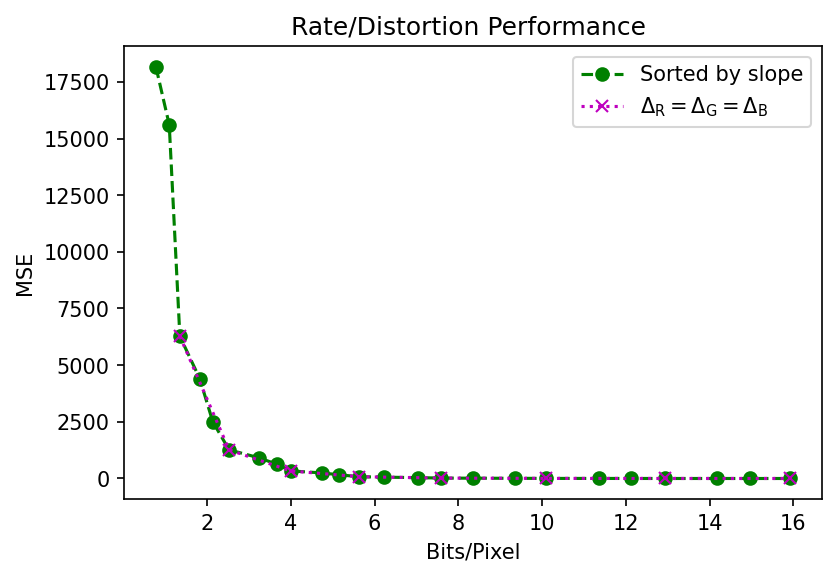

In [21]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_sorted_by_slopes), c='g', marker='o', label="Sorted by slope", linestyle="dashed")
pylab.plot(*zip(*constant_Q_RD_points), c='m', marker='x', label="$\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}}$", linestyle="dotted")
pylab.title("Rate/Distortion Performance ")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
pylab.legend(loc='upper right')
pylab.show()

## Conclusion

In the RGB domain, the optimal RD curve matches the constant quantization RD curve because the 3 components have the same weight in the contribution to the quality the reconstruction. However, we have more OTPs (Optimal Truncation Points) in the optimal one.

## For further comparations

In [23]:
with open('RGB.txt', 'w') as f:
    for item in RD_points_sorted_by_slopes:
        f.write(f"{item[0]}\t{item[1]}\n")

## Let's have a look ($\Delta_{\text{R}} = \Delta_{\text{G}} = \Delta_{\text{B}} = 64$)

In [ ]:
k, y = q_deq(img, 64)
show(y, "")

## Ignore the rest ...

In [ ]:
def accumulate_rate(points_sorted_by_slopes):
    optimal_points = []
    accumulated_BR = 0.0
    for i in points_sorted_by_slopes:
        BPP = i[1][0]; MSE = i[1][1]
        accumulated_BR += BPP
        optimal_points.append((accumulated_BR, MSE))
    return optimal_points

optimal_points = accumulate_rate(optimal_slopes)

In [ ]:
optimal_points

## Compute slopes

In [ ]:
def compute_slopes(RD_points):
    extended_RD_points = [(0.0, 9.0E9, '', -1)] + RD_points
    counter = 0
    RD_slopes = []
    for i in RD_points:
        BPP = i[0] # Rate 
        print(RD_points[counter])
        delta_BPP = BPP - extended_RD_points[counter][0]
        MSE = i[1] # Distortion
        delta_MSE = MSE - extended_RD_points[counter][1] 
        #print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
        if delta_BPP > 0:
            slope = delta_MSE/delta_BPP
        else:
            slope = 0
        RD_slopes.append((slope, i[2], i[3]))
        counter += 1
    return RD_slopes

RD_slopes = compute_slopes(sorted_RD_points)

In [ ]:
RD_slopes

In [ ]:
print(RD_points)

In [ ]:
with open('RGB.txt', 'w') as f:
    for item in RD_points:
        f.write(f"{item[0]}\t{item[1]}\n")

In [ ]:
k, y = q_deq(img, 64)
show(y, "")

## RD curves of each channel

In [ ]:
def only_R_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        R_frame = RGB_frame[:,:,0]
        k, dequantized_R_frame = q_deq(R_frame, 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_graypixel(k)
        _distortion = distortion.MSE(R_frame, dequantized_R_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_G_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        G_frame = RGB_frame[:,:,1]
        k, dequantized_G_frame = q_deq(G_frame, 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_graypixel(k)
        _distortion = distortion.MSE(G_frame, dequantized_G_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_B_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        B_frame = RGB_frame[:,:,2]
        k, dequantized_B_frame = q_deq(B_frame, 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_graypixel(k)
        _distortion = distortion.MSE(B_frame, dequantized_B_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

only_R_points = only_R_RD_curve(img)
only_G_points = only_G_RD_curve(img)
only_B_points = only_B_RD_curve(img)

In [ ]:
only_B_points

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points), c='m', marker="x",
           label='$\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$')
pylab.plot(*zip(*only_R_points), c='r', marker="o",
           label='Only R')              
pylab.plot(*zip(*only_G_points), c='g', marker="o",
           label='Only G')              
pylab.plot(*zip(*only_B_points), c='b', marker="o",
           label='Only B')              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

The $\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$ quantization scheme is near optimal because the slope at the different quantization points is almost the same. This can be seen in the next experiment

## Testing a different quantization configuration

In [ ]:
N = 6
def only_R_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        dequantized_RGB_frame = np.empty_like(RGB_frame)
        k = np.empty_like(RGB_frame)
        k[:,:,0], dequantized_RGB_frame[:,:,0] = q_deq(RGB_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_RGB_frame[:,:,1] = q_deq(RGB_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_RGB_frame[:,:,2] = q_deq(RGB_frame[:,:,2], 1<<N)
        k = k.astype(np.uint8)
        rate = bits_per_pixel(k)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_G_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        dequantized_RGB_frame = np.empty_like(RGB_frame)
        k = np.empty_like(RGB_frame)
        k[:,:,0], dequantized_RGB_frame[:,:,0] = q_deq(RGB_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_RGB_frame[:,:,1] = q_deq(RGB_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_RGB_frame[:,:,2] = q_deq(RGB_frame[:,:,2], 1<<N)
        k = k.astype(np.uint8)
        rate = bits_per_pixel(k)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

def only_B_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        dequantized_RGB_frame = np.empty_like(RGB_frame)
        k = np.empty_like(RGB_frame)
        k[:,:,0], dequantized_RGB_frame[:,:,0] = q_deq(RGB_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_RGB_frame[:,:,1] = q_deq(RGB_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_RGB_frame[:,:,2] = q_deq(RGB_frame[:,:,2], 1<<q_step)
        k = k.astype(np.uint8)
        rate = bits_per_pixel(k)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
    return RD_points

only_R_points = only_R_RD_curve(img)
only_G_points = only_G_RD_curve(img)
only_B_points = only_B_RD_curve(img)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points), c='m', marker="x",
           label='$\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$')
pylab.plot(*zip(*only_R_points), c='r', marker="o",
           label='$\Delta_{\mathrm{R}}~\mathrm{varies},~\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_G_points), c='g', marker="o",
           label='$\Delta_{\mathrm{G}}~\mathrm{varies},~\Delta_{\mathrm{R}}=\Delta_{\mathrm{B}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_B_points), c='b', marker="o",
           label='$\Delta_{\mathrm{B}}~\mathrm{varies},~\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=$' + '{}'.format(1<<N))              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

As it can be seen, the best configuration matches $\Delta_{\mathrm{R}} = \Delta_{\mathrm{G}} = \Delta_{\mathrm{B}}$.

Lo que hay que hacer es calcular el slope para cada OTP (Optimal Truncated Point) de cada canal, ordenarlos y trazar la curva RD. Esto nos daría la curva RD óptima.